In [1]:
from module import *
from tool import *
from test import *
import os
from IPython.display import clear_output

In [3]:
10000 // 10

1000

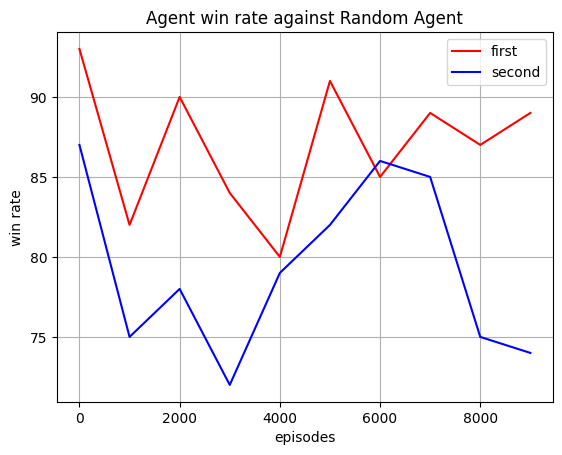

In [2]:
env = ConnectFourEnvironment()
input_size = 6 * 7  
output_size = 7 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(input_size, output_size, device)

model_path = "base/"
os.makedirs(model_path, exist_ok=True)

num_episodes = 10000
epsilon = 0.5
target_update_frequency = 100
update_plot_frequency = num_episodes // 10

results = []

# Training loop
for episode in (range(num_episodes)):
    state = env.get_state()
    done = False

    new_epsilon = max(0, epsilon - 5 * episode * epsilon / num_episodes)
    while not done:
        action = agent.select_action(state, env, new_epsilon)
        next_state, reward, done = env.step(action)
        
        agent.store_transition(Transition(state, action, next_state, reward))
        agent.train()
        
        state = next_state

    if episode % target_update_frequency == 0:
        agent.update_target_network()
        
    if episode % update_plot_frequency == 0:
        if episode != 0: torch.save(agent.policy_net.state_dict(), os.path.join(model_path, f"{episode}.pth"))
        f, s = TestCase(agent, 2000)
        results.append((episode, f, s))
        update_plot(results)
        clear_output(wait=True)
        
    env.reset()


dqn_net = DQN()
with open(os.path.join(model_path, "model.txt"), "w") as f:
    f.write(str(dqn_net) + f"\nEpsilon: {epsilon}\nResults: {results}" )
update_plot(results, os.path.join(model_path, "final.png"))